In [1]:
import numpy as np
import pandas as pd
import pickle
import glob
import copy
import seaborn as sns
import os

from sklearn import metrics

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker

from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import GridSpec

study_colors = ['C1', 'C0']
study_names = ['Study 1', 'Study 2']

In [2]:
pickle_file = 'data/all_results_study1.pkl'
with open(pickle_file, "rb") as file:
    res1 = pickle.load(file)
res1 = res1[~res1['pred_can+et'].isna()]

pickle_file = 'data/all_results_study2.pkl'
with open(pickle_file, "rb") as file:
    res2 = pickle.load(file)
res2 = res2[~res2['pred_can+et'].isna()]

res = [res1, res2]

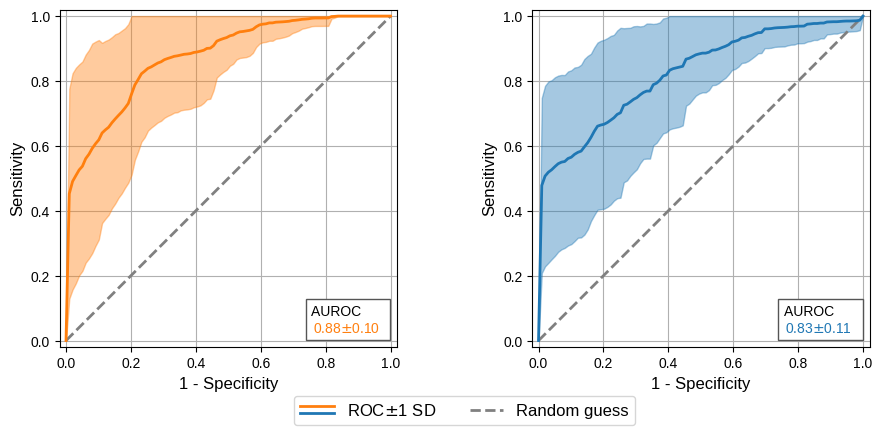

In [3]:
def auc_plot(ax, y_true, y_pred, subjects, label, color, prominent=True, xlabel=True, ylabel=True, sd=True, chance=True):
    if chance:
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Random guess', alpha=1)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100) 
    for t_id in subjects.unique():
        fpr, tpr, thresh = metrics.roc_curve(y_true[subjects == t_id], y_pred[subjects == t_id])
        auc = metrics.roc_auc_score(y_true[subjects == t_id], y_pred[subjects == t_id])

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    
    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=color, label=f'{label} (AUROC = {mean_auc:.2f}$\pm${np.std(aucs):.2f})', alpha=1 if prominent else .75, lw=2)

    # mean std area
    std_tpr = np.std(tprs, axis=0, ddof=1)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if sd:
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.4 if prominent else .2, label=r'$\pm$1 SD')
    
    ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02])

    text_color = '#000000'
    if ylabel:
        ax.set_ylabel('Sensitivity', color=text_color)
    if xlabel:
        ax.set_xlabel('1 - Specificity', color=text_color)
    
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_aspect('equal', 'box')
    return '%.2f$\pm$%.2f' % (mean_auc, std_auc)


fig, axs = plt.subplots(1, 2, figsize=(9, 4), facecolor='white')

# OVERALL PLOTS
for study in [0, 1]:
    model = "CAN+ET"
    
    ax = axs[study]
    data = res[study]

    score = auc_plot(ax, data[f'y_39'], data[f'pred_{model.lower()}'], data['subject_id'], model, study_colors[study],
                     prominent=True, xlabel=True, ylabel=True, sd=True)

    text_box = AnchoredText('AUROC      \n', prop=dict(fontsize='10'), frameon=True, loc='lower right', pad=0.4)
    plt.setp(text_box.patch, facecolor='white', edgecolor='#555555')
    ax.add_artist(text_box)

    ax.text(0.75, 0.035, score, transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color=study_colors[study], zorder=10)


# LEGEND
class LegendHandler(matplotlib.legend_handler.HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.8*height,0.8*height], color=study_colors[0])
        l2 = plt.Line2D([x0,y0+width], [0.2*height,0.2*height], color=study_colors[1])
        return [l1, l2]

lines = [object, mlines.Line2D([], [], linestyle='--', lw=2, color='grey', alpha=1)]
labels = ['ROC$\pm$1 SD', 'Random guess']
fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.45, -0.02), ncol=len(lines), handler_map={object: LegendHandler()})

fig.subplots_adjust(left=0, top=1, bottom=0.12, wspace=0.4)

plt.savefig(f'plots/ROC.svg', bbox_inches='tight')
plt.show()

# Precision-Recall Curves

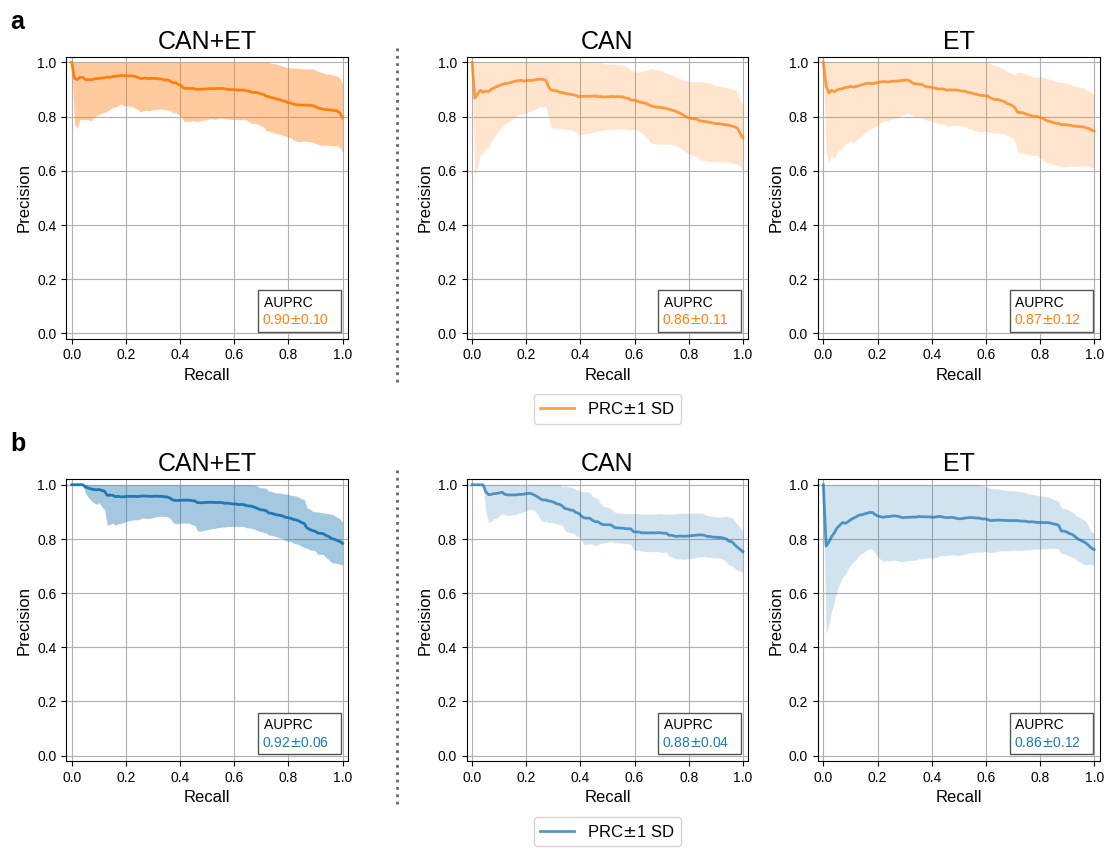

In [4]:
graph_colors = ['C1', 'C0']

scenario_colors = {
    'Highway': 'C4',
    'Rural': 'C8',
    'Town': 'C9',
}

def auc_plot(ax, y_true, y_pred, subjects, label, color, prominent=True, xlabel=True, ylabel=True, sd=True, chance=True):
    precs = []
    aucs = []
    mean_rec = np.linspace(1, 0, 100) 
    for t_id in subjects.unique():
        prec, recall, thresh = metrics.precision_recall_curve(y_true[subjects == t_id], y_pred[subjects == t_id])
        auc = metrics.average_precision_score(y_true[subjects == t_id], y_pred[subjects == t_id])

        interp_prec = np.flip(np.interp(np.flip(mean_rec), np.flip(recall), np.flip(prec)))
        interp_prec[-1] = 1.0
        if not np.isnan(auc):
            precs.append(interp_prec)
            aucs.append(auc)
            
    mean_prec = np.mean(precs, axis=0)
    mean_auc = metrics.auc(mean_rec, mean_prec)
    
    ax.plot(mean_rec, mean_prec, color=color, label=f'{label} (AUPRC = {mean_auc:.2f}$\pm${np.std(aucs):.2f})', alpha=1 if prominent else .75, lw=2)
        
    std_prec = np.std(precs, axis=0)
    tprs_upper = np.minimum(mean_prec + std_prec, 1)
    tprs_lower = np.maximum(mean_prec - std_prec, 0)
    if sd:
        ax.fill_between(mean_rec, tprs_lower, tprs_upper, color=color, alpha=.4 if prominent else .2, lw=0, label=r'$\pm$1 SD')

    text_color = '#000000'
    if ylabel:
        ax.set_ylabel('Precision', color=text_color)
    if xlabel:
        ax.set_xlabel('Recall', color=text_color)
        
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_aspect('equal', 'box')
    ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02])
    return '%.2f$\pm$%.2f' % (mean_auc, np.std(aucs))


#fig, axs = plt.subplots(2, 3, figsize=(12, 8), facecolor='white')
#plt.subplots_adjust(hspace=0.5)

fig = plt.figure(figsize=(12, 8), facecolor='white')
gs1 = GridSpec(2, 1, right=1/3 - 0.03)
gs2 = GridSpec(2, 2, left=1/3 + 0.03)
axs = np.empty([2, 3], dtype=object)

axs[0][0] = fig.add_subplot(gs1[0,0])
axs[1][0] = fig.add_subplot(gs1[1,0])
axs[0][1] = fig.add_subplot(gs2[0,0])
axs[1][1] = fig.add_subplot(gs2[1,0])
axs[0][2] = fig.add_subplot(gs2[0,1])
axs[1][2] = fig.add_subplot(gs2[1,1])

plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate([axs[0, 0], axs[1, 0]]):
    x = 1.2
    ax.plot([x, x], [-0.18, 1.06], color='#666', linestyle=':', linewidth=2, clip_on=False)

# OVERALL PLOTS
for study in [0, 1]:
    for column, model in enumerate(['CAN+ET', 'CAN', 'ET']):
        ax = axs[study][column]
        data = res[study]
        
        score = auc_plot(ax, data[f'y_39'], data[f'pred_{model.lower()}'], data['subject_id'], model, study_colors[study],
                         prominent=model=='CAN+ET', xlabel=True, ylabel=True, sd=True)

        text_box = AnchoredText('AUPRC      \n', prop=dict(fontsize='10'), frameon=True, loc='lower right', pad=0.4)
        plt.setp(text_box.patch, facecolor='white', edgecolor='#555555')
        ax.add_artist(text_box)

        ax.text(0.695, 0.04, score, transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color=study_colors[study], zorder=10)
        ax.set_title(model)

    # LEGEND
    lines, labels = axs[study][1].get_legend_handles_labels()

    lines = [x for i, x in sorted(zip([1], lines))]
    labels = [x for i, x in sorted(zip([1], labels))]

    lines[0] = copy.copy(lines[0])
    lines[0].set_color(study_colors[study])
    labels[0] = 'PRC$\pm$1 SD'

    axs[study][1].legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.25), ncol=len(lines))# facecolor='white', edgecolor='black', framealpha=1, fancybox=False)

# LEGEND 2
fig.subplots_adjust(left=0, top=1, bottom=0.12)

pad = 20 # in points
for ax, letter in zip([axs[0][0], axs[1][0]], list('ab')):
    ax.text(-0.2, 1.1, letter, transform=ax.transAxes, fontsize='18', weight='bold')
    
plt.savefig(f'plots/PRC.svg', bbox_inches='tight')
plt.show()

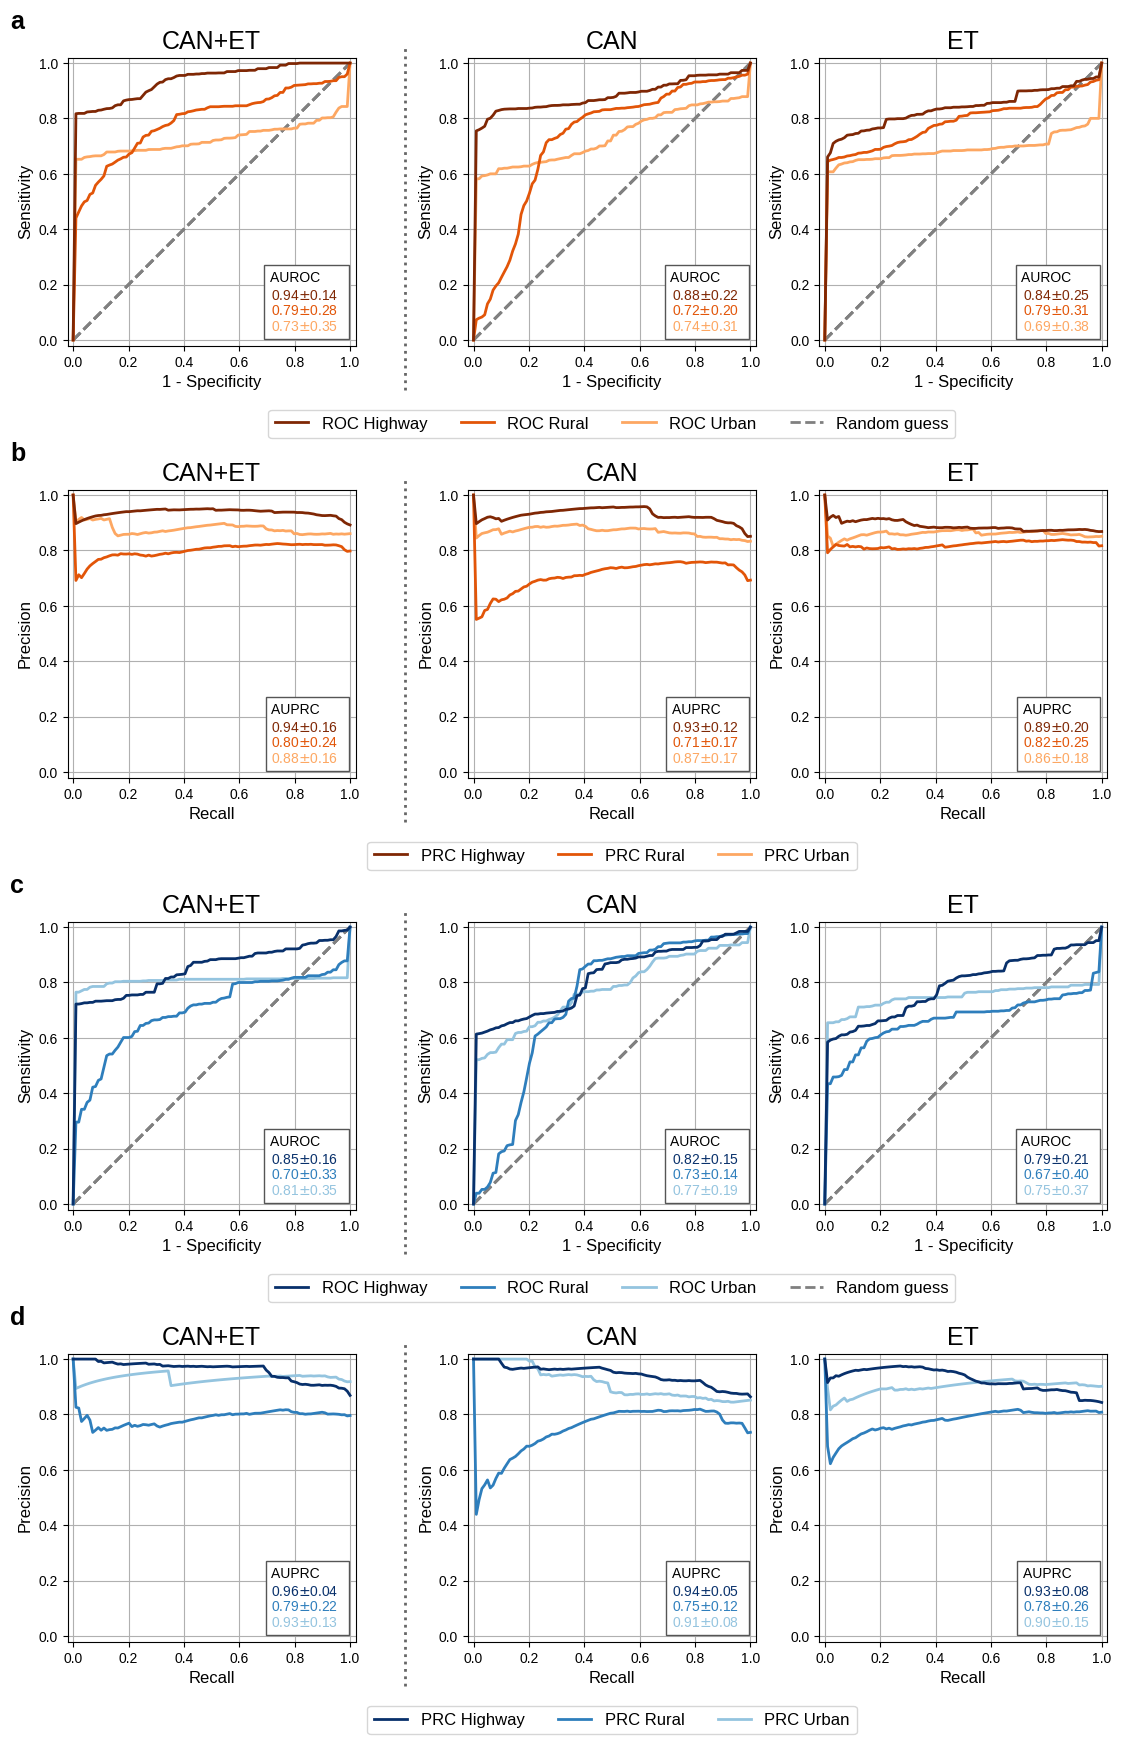

In [5]:
colors_study1 = plt.cm.Oranges(np.linspace(1, 0.4, 3))
colors_study2 = plt.cm.Blues(np.linspace(1, 0.4, 3))

scenario_colors = {
    'Highway': (colors_study1[0], colors_study2[0]),
    'Rural': (colors_study1[1], colors_study2[1]),
    'Town': (colors_study1[2], colors_study2[2])
}

def roc_plot(ax, y_true, y_pred, subjects, label, color, prominent=True, xlabel=True, ylabel=True, sd=True, chance=True, order=0):
    if chance:
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=1)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100) 
    for t_id in subjects.unique():
        fpr, tpr, thresh = metrics.roc_curve(y_true[subjects == t_id], y_pred[subjects == t_id])
        auc = metrics.roc_auc_score(y_true[subjects == t_id], y_pred[subjects == t_id])

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    
    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=color, label=f'{label} (AUROC = {mean_auc:.2f}$\pm${np.std(aucs):.2f})', alpha=1 if prominent else .75, lw=2, zorder=order)

    # mean std area
    std_tpr = np.std(tprs, axis=0, ddof=1)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if sd:
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.4 if prominent else .2, label=r'$\pm$1 SD')
         
    ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02])

    text_color = '#000000'
    if ylabel:
        ax.set_ylabel('Sensitivity', color=text_color)
    if xlabel:
        ax.set_xlabel('1 - Specificity', color=text_color)
    
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_aspect('equal', 'box')
    return '%.2f$\pm$%.2f' % (mean_auc, std_auc)


def prc_plot(ax, y_true, y_pred, subjects, label, color, prominent=True, xlabel=True, ylabel=True, sd=True, order=0):
    precs = []
    aucs = []
    mean_rec = np.linspace(1, 0, 100) 
    for t_id in subjects.unique():
        prec, recall, thresh = metrics.precision_recall_curve(y_true[subjects == t_id], 
                                                              y_pred[subjects == t_id])
        auc = metrics.average_precision_score(y_true[subjects == t_id], 
                                              y_pred[subjects == t_id])

        interp_prec = np.flip(np.interp(np.flip(mean_rec), np.flip(recall), np.flip(prec)))
        interp_prec[-1] = 1.0
        if not np.isnan(auc):
            precs.append(interp_prec)
            aucs.append(auc)
            
    mean_prec = np.mean(precs, axis=0)
    #mean_prec[-1] = 0.0
    mean_auc = metrics.auc(mean_rec, mean_prec)
    
    ax.plot(mean_rec, mean_prec, color=color, label=f'{label} (AUPRC = {mean_auc:.2f}$\pm${np.std(aucs):.2f})', alpha=1 if prominent else .75, lw=2, zorder=order)
        
    std_prec = np.std(precs, axis=0)
    tprs_upper = np.minimum(mean_prec + std_prec, 1)
    tprs_lower = np.maximum(mean_prec - std_prec, 0)
    if sd:
        ax.fill_between(mean_rec, tprs_lower, tprs_upper, color=color, alpha=.4 if prominent else .2, label=r'$\pm$1 SD')
       
    ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02])

    text_color = '#000000'
    if ylabel:
        ax.set_ylabel('Precision', color=text_color)
    if xlabel:
        ax.set_xlabel('Recall', color=text_color)
        
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_aspect('equal', 'box')
    return '%.2f$\pm$%.2f' % (mean_auc, np.std(aucs))


fig = plt.figure(figsize=(12, 18), facecolor='white')
gs1 = GridSpec(4, 1, right=1/3 - 0.03)
gs2 = GridSpec(4, 2, left=1/3 + 0.03)
axs = np.empty([4, 3], dtype=object)

axs[0][0] = fig.add_subplot(gs1[0,0])
axs[1][0] = fig.add_subplot(gs1[1,0])
axs[2][0] = fig.add_subplot(gs1[2,0])
axs[3][0] = fig.add_subplot(gs1[3,0])
axs[0][1] = fig.add_subplot(gs2[0,0])
axs[1][1] = fig.add_subplot(gs2[1,0])
axs[2][1] = fig.add_subplot(gs2[2,0])
axs[3][1] = fig.add_subplot(gs2[3,0])
axs[0][2] = fig.add_subplot(gs2[0,1])
axs[1][2] = fig.add_subplot(gs2[1,1])
axs[2][2] = fig.add_subplot(gs2[2,1])
axs[3][2] = fig.add_subplot(gs2[3,1])

plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs[:, 0]):
    x = 1.2
    ax.plot([x, x], [-0.18, 1.06], color='#666', linestyle=':', linewidth=2, clip_on=False)


# ENVIRONMENT PLOTS
row = 0
for study in [0, 1]:
    for curve in ['roc', 'prc']:
        for idx, env in enumerate(['Highway', 'Rural', 'Town']):
            for column, model in enumerate(['CAN+ET', 'CAN', 'ET']):

                ax = axs[row, column]

                data = res[study][res[study]['env'] == env]
        
                plot_function = roc_plot if curve == 'roc' else prc_plot
                score = plot_function(ax, data[f'y_39'], data[f'pred_{model.lower()}'], data['subject_id'], model, scenario_colors[env][study],
                                 prominent=True, xlabel=True, ylabel=True, sd=False, order=100-idx)

                if idx == 0:
                    text_box = AnchoredText(f'{"AUROC" if curve == "roc" else "AUPRC"}      \n\n\n', prop=dict(fontsize='10'), frameon=True, loc='lower right', pad=0.4)
                    plt.setp(text_box.patch, facecolor='white', edgecolor='#555555')
                    ax.add_artist(text_box)

                ax.text(0.707, 0.15-idx*0.055, score, transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color=scenario_colors[env][study], zorder=10)
                ax.set_title(model)

        row += 1

# LEGEND bottom
fig.subplots_adjust(left=0, top=1, bottom=0.12)

for row, (ax, curve) in enumerate(zip(axs[:, 1], ['ROC', 'PRC', 'ROC', 'PRC'])):
    lines = []
    labels = []
    for k, v in scenario_colors.items():
        if k is 'Town':
            k = 'Urban'
        labels.append(f'{curve} {k}')
        lines.append(matplotlib.lines.Line2D([0], [0], color=v[row // 2], lw=2, label=f'{k}'))
    if curve is 'ROC':
        labels.append('Random guess')
        lines.append(matplotlib.lines.Line2D([0], [0], linestyle='--', lw=2, color='grey', label='Chance', alpha=1))

    ax.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=len(labels))
        

# ANNOTATIONS
for ax, letter in zip(axs[:, 0], list('abcd')):
    ax.text(-0.2, 1.1, letter, transform=ax.transAxes, fontsize='18', weight='bold')

    
plt.savefig(f'plots/auc_scenarios.svg', bbox_inches='tight')
plt.show()

# Coefficient Plots

In [6]:
FEATURE_DESCRIPTION = {
    'velocity_std_car': "CAN: SD of\nvehicle velocity",
    'gas_std_car': "CAN: SD of\ngas pedal position",
    'brake_std_car': "CAN: SD of\nbrake pedal position",
    'steer_std_car': "CAN: SD of\nsteering wheel angle",
    'velocity_energy_car': "CAN: energy of\nvehicle velocity",
    'gas_energy_car': "CAN: energy of\ngas pedal position",
    'brake_energy_car': "CAN: energy of\nbrake pedal position",
    'steer_energy_car': "CAN: energy of\nsteering wheel angle",
    'gaze+mean_v_eye': "ET: mean of\ngaze velocity",
    'gaze+std_v_eye': "ET: SD of\ngaze velocity",
    'fixationduration+count_eye': "ET: count of\ngaze fixations",
    'fixationduration+std_duration_eye': "ET: SD duration of\ngaze fixations",
}

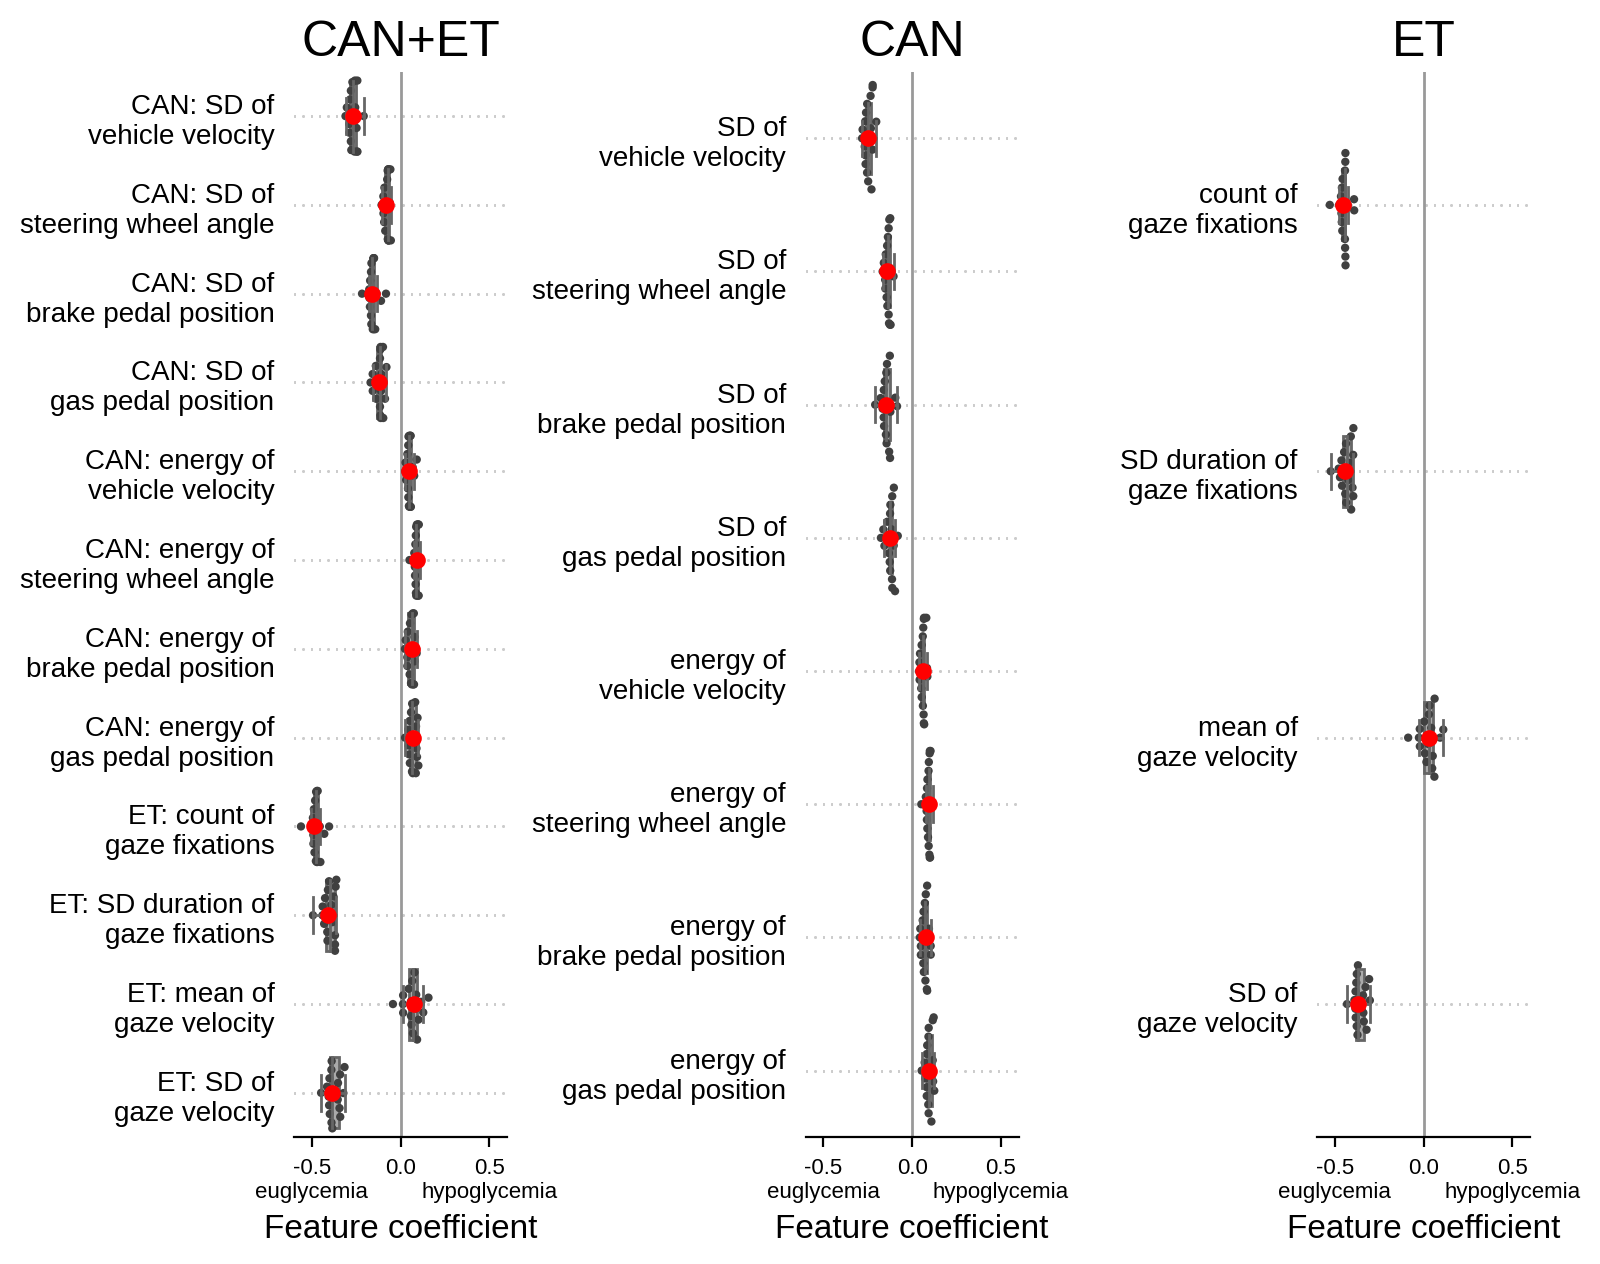

In [7]:
import warnings
warnings.filterwarnings("ignore")

def plot_coefs(coefs, features, train_coefs, desc, ax, plot_train=True):
    coefs = np.squeeze(coefs)
    df_coefs = pd.DataFrame(data=coefs, columns=features).melt()
    df_coefs['abs_value'] = df_coefs.value.abs()
    df_coefs_grouped = df_coefs.groupby('variable').agg('mean')
    df_coefs_grouped = df_coefs_grouped.sort_values(by='abs_value', ascending=False)
    top_feat_list = list(df_coefs_grouped.index)

    ax.axvline(x=0, color="#999999", linewidth=1, zorder=-1)
    ax.set_xlim([-0.6, 0.6])
    ax.set_xticks([-0.5, 0, 0.5])
    ax.set_xticklabels(['-0.5\neuglycemia', 0.0, '0.5\nhypoglycemia'])
    df_coefs['variable'] = df_coefs['variable'].map(FEATURE_DESCRIPTION)
    if desc == 'CAN':
        df_coefs['variable'] = df_coefs['variable'].str[5:]
    if desc == 'ET':
        df_coefs['variable'] = df_coefs['variable'].str[4:]
    sns.boxplot(y='variable', x='value', data=df_coefs, ax=ax, orient='h',
                color='#aaaaaa',
                width=0.8*(len(df_coefs.variable.unique())/12),
                fliersize=0,
                zorder=10,
                linewidth=1,
                )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    for coef in df_coefs['variable']:
        ax.axhline(y=coef, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-100)
    ax.grid(axis='y')
    sns.swarmplot(y='variable', x='value', size=3, data=df_coefs, ax=ax, orient='h', color=".25")
    
    if plot_train:
        df_train_coefs = pd.DataFrame(data=train_coefs, columns=features).melt()
        df_train_coefs['variable'] = df_train_coefs['variable'].map(FEATURE_DESCRIPTION)
        if desc == 'CAN':
            df_train_coefs['variable'] = df_train_coefs['variable'].str[5:]
        if desc == 'ET':
            df_train_coefs['variable'] = df_train_coefs['variable'].str[4:]
        sns.swarmplot(y='variable', x='value', size=6, data=df_train_coefs, ax=ax, orient='h', color="red", zorder=100)
        
    ax.set(title=desc)
    ax.set_xlabel('Feature coefficient')
    ax.set_ylabel(None)


with open('data/coefs.pkl', 'rb') as f:
    coefs_pickle = pickle.load(f)

with plt.rc_context({'xtick.labelsize': 8}):   
    fig, axs = plt.subplots(1, 3, figsize=(7, 6), dpi=200)
    fig.tight_layout()
    fig.subplots_adjust(wspace=1.4)

for col, desc in enumerate(['CAN+ET', 'CAN', 'ET']):
    value = coefs_pickle[desc]
    coefs, features, train_coefs = value['coefs'], value['features'], value['train_coefs']
    plot_coefs(coefs, features, train_coefs, desc, ax=axs[col])
    
    
plt.savefig(f'plots/model_coefficients.svg', bbox_inches='tight')
plt.show()

# Supplementary Plot (ROC/PRC)

In [8]:
pickle_file = 'data/all_results_study2.pkl'
    
with open(pickle_file, "rb") as file:
    df = pickle.load(file)
df.head()

STUDY_1_SUBJECTS = [105, 106, 107, 108, 111, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 127, 129]
STUDY_2_SUBJECTS = [301, 302, 303, 304, 307, 310, 312, 313, 315]

df['study'] = np.nan
df.loc[df['subject_id'].isin(STUDY_1_SUBJECTS), 'study'] = 1
df.loc[df['subject_id'].isin(STUDY_2_SUBJECTS), 'study'] = 2

df = df.dropna(subset=['study'])

def enumerate_phase(df):
    #print(df)
    df = df.sort_values(by='datetime_start')
    df['order'] = [1, 2, 3]
    return df#.set_index(['phase', 'subject_id', 'env'])
data = df.reset_index().groupby(['phase', 'subject_id', 'env']).agg({'bg_mean': 'first', 'cgm_mean': 'mean', 'datetime_start': 'first'}).reset_index().groupby(['phase', 'subject_id']).apply(enumerate_phase).reset_index(drop=True)

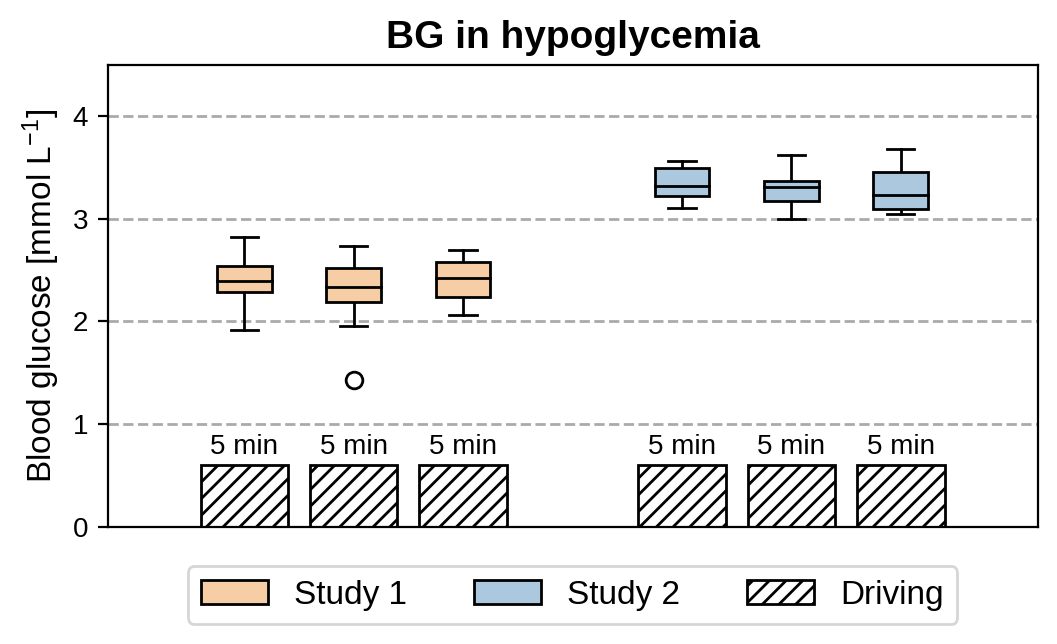

In [9]:
from matplotlib.patches import Rectangle

bg1_data = np.array(data[data['subject_id'].isin(STUDY_1_SUBJECTS) & (data['phase'] == 3)].groupby(['phase', 'order'])['bg_mean'].apply(list))
bg2_data = np.array(data[data['subject_id'].isin(STUDY_2_SUBJECTS) & (data['phase'] == 3)].groupby(['phase', 'order'])['bg_mean'].apply(list))
cgm1_data = np.array(data[data['subject_id'].isin(STUDY_1_SUBJECTS) & (data['phase'] == 3)].groupby(['phase', 'order'])['cgm_mean'].apply(list))
cgm2_data = np.array(data[data['subject_id'].isin(STUDY_2_SUBJECTS) & (data['phase'] == 3)].groupby(['phase', 'order'])['cgm_mean'].apply(list))


def lighten_color(color, amount=0.1):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


bg1_color = '#f7cda5' #study_colors[0]
bg2_color = '#acc8df' #study_colors[1]
cgm1_color = lighten_color(bg1_color)
cgm2_color = lighten_color(bg2_color)

ticks = ['Study 1', 'Study 2']

def set_box_color(bp, color):
    plt.setp(bp['medians'], color='black')
    
    for patch in bp['boxes']:
        patch.set_facecolor(color)

fig = plt.figure(figsize=(6,3), dpi=200, facecolor='white')
ax = plt.gca()

positions1 = np.array(range(len(bg1_data))) * 2.0 + np.array([0,0,0])
positions2 = np.array(range(len(bg1_data), len(bg1_data) + len(bg2_data))) * 2.0 + np.array([2,2,2])
#positions += np.arange(len(positions))/4

bpl1 = ax.boxplot(bg1_data, positions=positions1, widths=1, patch_artist=True)
bpl2 = ax.boxplot(bg2_data, positions=positions2, widths=1, patch_artist=True)
set_box_color(bpl1, bg1_color)
set_box_color(bpl2, bg2_color)

drive_color='#FFFFFF'
drive_hatch='////'
for position in list(positions1) + list(positions2):
    rect_width = 1.6
    rect_height = 0.8
    ax.add_patch(Rectangle((position - rect_width/2, -0.2), rect_width, rect_height,
             edgecolor = 'black',
             #hatch=hatches[idx // 3],
             hatch=drive_hatch,
             facecolor=drive_color,
             alpha=1,
             fill=True,
             lw=1))

    ax.annotate('5 min', (position, -0.2 + rect_height+0.05), color='black', fontsize=10, ha='center', va='bottom')


plt.xticks([positions1[1], positions2[1]], ticks, fontweight='bold')
plt.xticks([])
ax.set_ylim(0, 4.5)
ax.set_xlim(-2.5, 2 * 6 + 2.5)
ax.set_ylabel(r'Blood glucose [$\mathregular{mmol\ L^{-1}}$]')
plt.yticks([0,1,2,3,4])

#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['right'].set_visible(False)

plt.tick_params(bottom=False)

ax.set_title('BG in hypoglycemia', fontweight='bold', fontsize=14)

ax.grid(color='#aaaaaa', which='major', linestyle='--', linewidth=1, axis='y')

phase_patches = [
    matplotlib.patches.Patch(facecolor=bg1_color, edgecolor='black', label=f'{study_names[0]}'),
    matplotlib.patches.Patch(facecolor=bg2_color, edgecolor='black', label=f'{study_names[1]}'),
    matplotlib.patches.Patch(facecolor=drive_color, edgecolor='black', hatch=drive_hatch, label='Driving', alpha=1)
]

#ax.legend(handles = phase_patches)
ax.legend(handles = phase_patches, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=len(phase_patches))

plt.savefig('plots/bg-boxplots.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)

# BG curves

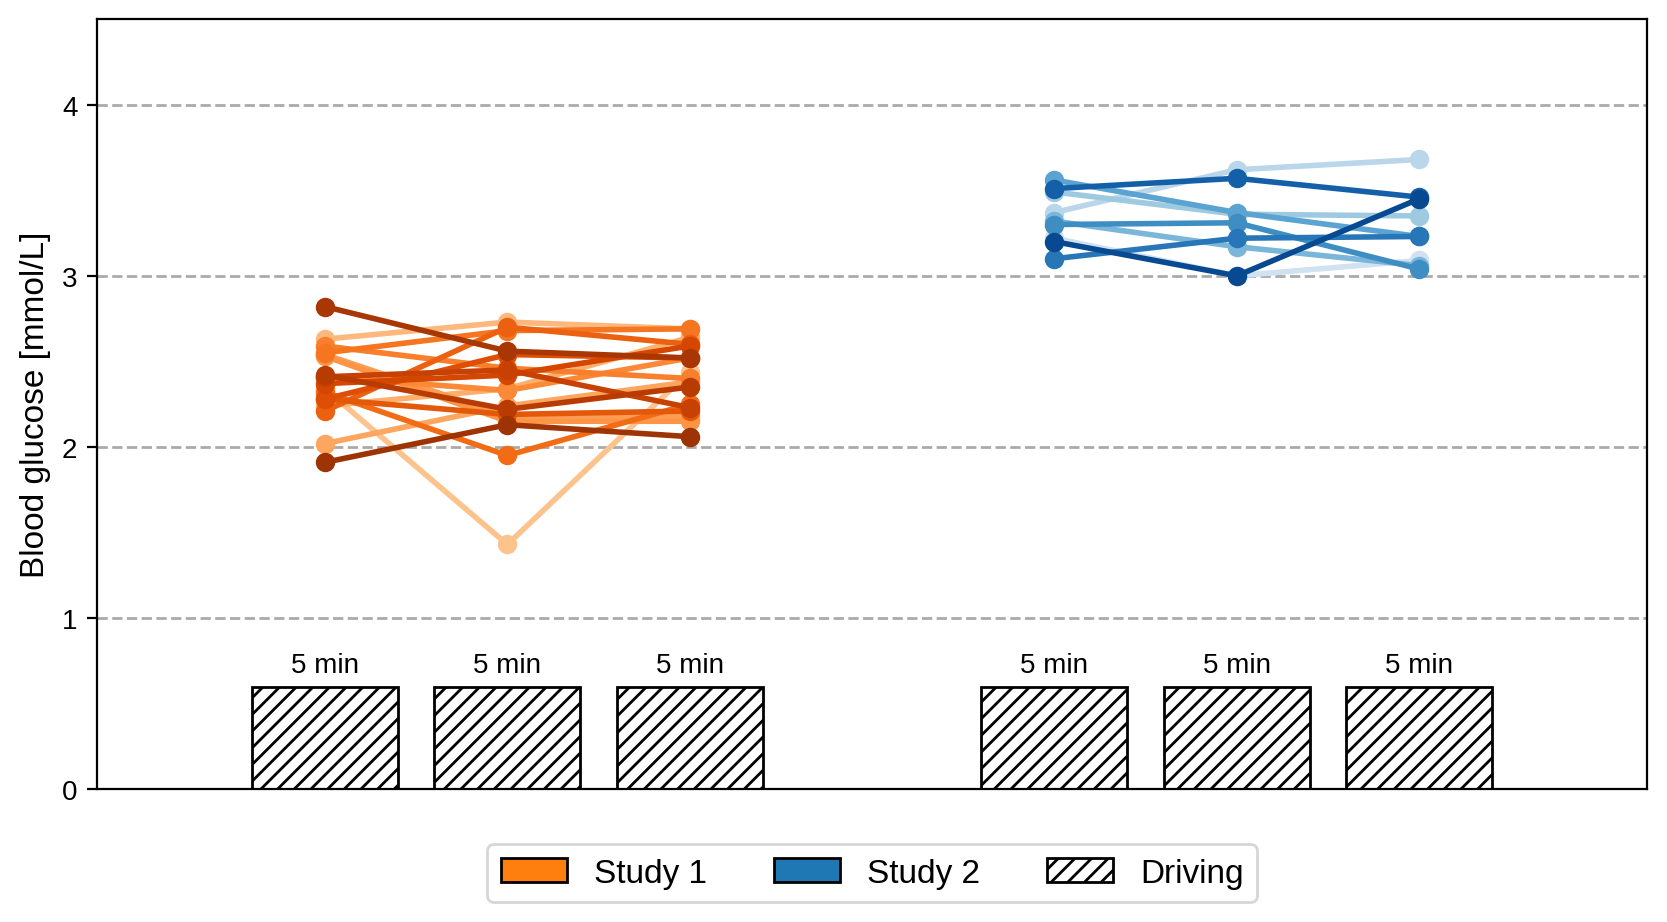

In [10]:
bg1_data = np.concatenate(data[data['subject_id'].isin(STUDY_1_SUBJECTS)].groupby(['phase', 'order'])['bg_mean'].apply(np.array).values).reshape(6, -1)
bg2_data = np.concatenate(data[data['subject_id'].isin(STUDY_2_SUBJECTS)].groupby(['phase', 'order'])['bg_mean'].apply(np.array).values).reshape(6, -1)

bg1_color = 'C1'
bg2_color = 'C0'

def set_box_color(bp, color):
    plt.setp(bp['medians'], color='black')
    
    for patch in bp['boxes']:
        patch.set_facecolor(color)

fig = plt.figure(figsize=(10,5), dpi=200, facecolor='white')
ax = plt.gca()

positions = np.array(np.arange(12) * 2.0 + np.array([0,0,0,2,2,2,6,6,6,8,8,8]))
#positions += np.arange(len(positions))/4

colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(bg1_data[0])))
for i in range(len(bg1_data[0])):
    ax.plot(positions[0:3], bg1_data[0:3, i], lw=2, marker='o', color=colors[i])
    ax.plot(positions[6:9], bg1_data[3:6, i], lw=2, marker='o', color=colors[i])

colors = plt.cm.Blues(np.linspace(0.2, 0.9, len(bg2_data[0])))
for i in range(len(bg2_data[0])):
    ax.plot(positions[3:6], bg2_data[0:3, i], lw=2, marker='o', color=colors[i])
    ax.plot(positions[9:12], bg2_data[3:6, i], lw=2, marker='o', color=colors[i])

drive_color='#FFFFFF'
drive_hatch='////'
for idx in range(len(positions)):
    rect_width = 1.6
    rect_height = 0.8
    ax.add_patch(Rectangle((positions[idx] - rect_width/2, -0.2), rect_width, rect_height,
             edgecolor = 'black',
             #hatch=hatches[idx // 3],
             hatch=drive_hatch,
             facecolor=drive_color,
             alpha=1,
             fill=True,
             lw=1))

    ax.annotate('5 min', (positions[idx], -0.2 + rect_height+0.05), color='black', fontsize=10, ha='center', va='bottom')


ticks = [study_names[0], study_names[1], study_names[0], study_names[1]]
plt.xticks([positions[1], positions[4], positions[7], positions[10]], ticks, fontweight='bold')
plt.xticks([])
ax.set_xlim(-2.5 + 18, 30 + 2.5)

plt.yticks([0,1,2,3,4,5])
ax.set_ylim(0, 4.5)
ax.set_ylabel('Blood glucose [mmol/L]')


plt.tick_params(bottom=False)
ax.yaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3, 4, 5]))
ax.grid(color='#aaaaaa', which='major', linestyle='--', linewidth=1, axis='y')

phase_patches = [
    matplotlib.patches.Patch(facecolor=study_colors[0], edgecolor='black', label=f'{study_names[0]}'),
    matplotlib.patches.Patch(facecolor=study_colors[1], edgecolor='black', label=f'{study_names[1]}'),
    matplotlib.patches.Patch(facecolor=drive_color, edgecolor='black', hatch=drive_hatch, label='Driving', alpha=1)
]

ax.legend(handles = phase_patches, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=len(phase_patches))

plt.savefig('plots/individual-glucose-values.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)

In [11]:
pickle_file = 'data/all_results_study1.pkl'
with open(pickle_file, "rb") as file:
    res1 = pickle.load(file)
#res1 = res1[~res1['pred_can+et'].isna()]
#print(res1.head())

pickle_file = 'data/all_results_study2.pkl'
with open(pickle_file, "rb") as file:
    res2 = pickle.load(file)
#res2 = res2[~res2['pred_can+et'].isna()]
res2.head()

X = pd.concat([res1, res2])

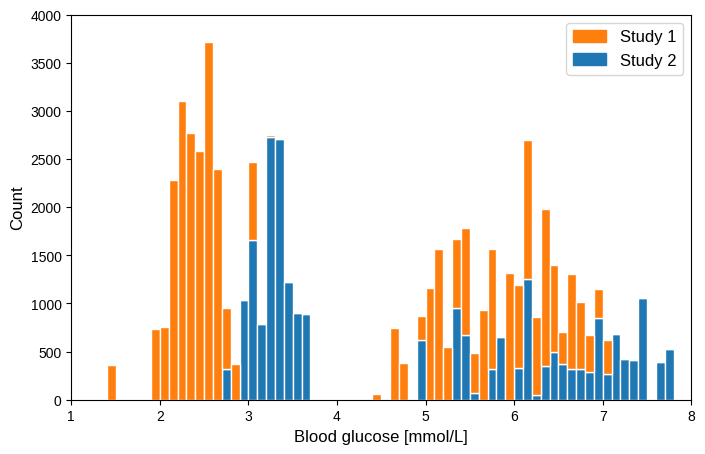

In [12]:
plt.figure(figsize=(8,5))

X['group'] = (X['subject_id'] > 200).astype(int)

measurement = 'bg_mean'

rounded_data = np.around(X[measurement], 1)
binwidth=0.1
ax = sns.histplot(data=X, x=measurement, ax=plt.gca(),
             hue="group",
             alpha=1,
             palette=study_colors,
             binwidth=binwidth,
             binrange=(np.floor(np.min(rounded_data)*(1/binwidth))/(1/binwidth), np.ceil(np.max(rounded_data)*(1/binwidth))/(1/binwidth)),
             multiple="stack",
             linewidth=1,
             edgecolor='white',
             stat="count",
            )
ax.set_ylim([0, 4000])
ax.set_xlim([1, 8])
ax.set_xlabel('Blood glucose [mmol/L]')
ax.set_ylabel('Count')

phase_patches = [
    matplotlib.patches.Patch(color=study_colors[0], label='Study 1'),
    matplotlib.patches.Patch(color=study_colors[1], label='Study 2'),
]

ax.legend(handles = phase_patches[:len(X['group'].unique())])

plt.savefig(f'plots/bg_distribution_groups.svg', bbox_inches='tight')